In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/VidyaAnalytics_HRAnalytics/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/data/VidyaAnalytics_HRAnalytics


In [ ]:
# Imports

!pip install scikit-learn==0.24.1 category_encoders
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import DataFrame
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import time
import string
import re
from scipy import sparse
from joblib import Parallel

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import delayed
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
# Function for printing different scores
def print_scores(model, X_test, y_test, mode='Test'):
  from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

  print(f"\n {mode} Set ROC AUC: ".format(mode), round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),2))
  print(f'\n Clasification Report on {mode} Set:\n'.format(mode), classification_report(y_test,model.predict(X_test)))
  print(f'\n Confussion Matrix:\n',confusion_matrix(y_test, model.predict(X_test)))

In [ ]:
# Defining encoder/transformer classes

class FeatureUnionPandas(FeatureUnion):

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
#         from joblib import Parallel
#         from sklearn.utils.fixes import delayed
       
       
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(pipeline._transform_one)(trans, X, None, weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
       
        # print("Processing FeatureUnion at:", round(time.time()/60)%1000, 'minutes')
       
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
   
    def fit_transform(self, X, y=None, **fit_params):
       
        results = self._parallel_func(X, y, fit_params, pipeline._fit_transform_one)

        if not results:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
       
        # print("Processing FeatureUnion at:", round(time.time()/60)%1000, 'minutes')
       
        Xs, transformers = zip(*results)
       
        self._update_transformer_list(transformers)
       
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs


class RareLabelCategoricalEncoder(BaseEstimator, TransformerMixin):
    """Rare label categorical encoder"""

    def __init__(self, variables=None, tol=0.001):
        self.tol = tol
        self.variables = variables

    def fit(self, X, y=None):

        if not isinstance(self.variables, list):
            self.variables = sorted([self.variables])
        else:
            self.variables = sorted(self.variables)
           
        # for compatibility with ColumnTransformer
        if self.variables == [None]:
            self.variables = X.columns
           
        # persist frequent labels in dictionary
        self.encoder_dict_ = {}

        X = X[self.variables].copy()
        for var in self.variables:
            X[var] = X[var].replace(r'^\s*$', np.nan, regex=True).fillna('ZZ').astype('str')
            # the encoder will learn the most frequent categories
            t = pd.Series(X[var].value_counts() / np.float(len(X)))
            # frequent labels:
            self.encoder_dict_[var] = list(t[t >= self.tol].index)

        return self

    def transform(self, X):
        # print("Processing RareLabelCategoricalEncoder at:", round(time.time()/60)%1000, 'minutes')
       
        X = X[self.variables].copy()
        for feature in self.variables:
            X[feature] = X[feature].replace(r'^\s*$', np.nan, regex=True).fillna('missing_value').astype('str')
            X[feature] = np.where(X[feature].isin(self.encoder_dict_[feature]), X[feature], 'Rare')
        return X


class StandardScalerPandas(BaseEstimator, TransformerMixin):
   
    def __init__(self):
        None
       
    def fit(self, X, y=None):
       
        self.columns = X.columns
        self.scaler = StandardScaler() #RobustScaler(unit_variance=True)
        self.scaler.fit(X)
       
        return self
   
    def transform(self, X):
       
        X = X.copy()
        index = X.index.values
        X = DataFrame(self.scaler.transform(X), index = index, columns = self.columns)
       
        return X

class num_fillna(BaseEstimator, TransformerMixin):
  def __init__(self, nan_variable = None, all_num_variables = None, grpby_var= None):
    self.nan_variable = nan_variable
    self.all_num_variables = all_num_variables
    self.grpby_var = grpby_var

  def fit(self, X, y=None):
    X = X[self.all_num_variables].copy()
    self.X_median = X.median()
    self.X_grpby = X.groupby(self.grpby_var)[[self.nan_variable]].median().reset_index()
    return self

  def transform(self, X):
    X = X[self.all_num_variables].copy()
    if self.nan_variable is not None:
      for i in self.X_grpby[self.grpby_var]:
        X.loc[X[self.grpby_var]==i, self.nan_variable] = X[X[self.grpby_var]==i][[self.nan_variable]].fillna(self.X_grpby[self.X_grpby[self.grpby_var] == i][self.nan_variable].values[0])
    X = X.fillna(self.X_median)
    return X

In [ ]:
df = pd.read_csv("train_set.csv")
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [ ]:
df.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
1%,795.070000,1.000000,23.000000,1.000000,1.000000,0.000000,0.000000,44.000000,0.000000
10%,7849.700000,1.000000,27.000000,1.000000,2.000000,0.000000,0.000000,48.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
90%,70459.300000,2.000000,46.000000,5.000000,11.000000,1.000000,0.000000,83.000000,0.000000


In [ ]:
df.isnull().mean().sort_values(ascending = False)*100

previous_year_rating    7.524449
education               4.395344
is_promoted             0.000000
avg_training_score      0.000000
awards_won?             0.000000
KPIs_met >80%           0.000000
length_of_service       0.000000
age                     0.000000
no_of_trainings         0.000000
recruitment_channel     0.000000
gender                  0.000000
region                  0.000000
department              0.000000
employee_id             0.000000
dtype: float64

In [ ]:
df1 = df.drop("employee_id",axis = 1)

In [ ]:
# Creating Pipelines

num_cols = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'avg_training_score']
cat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'KPIs_met >80%', 'awards_won?']

num_pipe = Pipeline([('num_fill_na', num_fillna(nan_variable = "previous_year_rating",all_num_variables = num_cols, grpby_var = 'length_of_service')),
                     ('num_standard_scaler', StandardScalerPandas())
                     ])

# num_fillna(nan_variable = None, all_num_variables = None, grpby_var= None)


cat_pipe = Pipeline([('rare_label_encoder', RareLabelCategoricalEncoder(variables=cat_cols)),
                     ('woe_encoder', ce.WOEEncoder(cols=cat_cols, return_df=True)),
                     ('cat_standard_scaler', StandardScalerPandas())
                    ])

combined_pipe = FeatureUnionPandas([('num', num_pipe),
                                    ('cat', cat_pipe)])

# Splitting into Train and Test Set

In [ ]:
# Putting feature variables in X
X = df1.drop(["is_promoted"], axis=1)

# Putting response variable in y
y = df1["is_promoted"]

# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100)

In [ ]:
X_train_processed = combined_pipe.fit_transform(X_train,y_train)
X_test_processed = combined_pipe.transform(X_test)

In [ ]:
# Processed X_train
X_train_processed.head()

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score,KPIs_met >80%,awards_won?,department,education,gender,recruitment_channel,region
41184,-0.415152,-1.149387,-0.250556,-0.902695,-0.326959,-0.737471,-0.152415,0.320383,-0.229638,1.534235,0.078409,1.901683
13041,-0.415152,0.677468,-0.250556,0.494560,1.543637,-0.737471,-0.152415,0.824509,1.163155,-0.651791,0.078409,-0.857807
40396,-0.415152,0.546978,1.394590,1.193187,-1.524140,-0.737471,-0.152415,-0.816642,1.163155,1.534235,-0.308972,1.901683
42434,1.220095,0.025020,1.394590,0.960311,-0.177311,-0.737471,-0.152415,0.320383,-0.229638,-0.651791,-0.308972,-0.063537
54002,-0.415152,-0.496939,-0.250556,-0.436943,-0.102487,-0.737471,-0.152415,0.320383,-0.229638,-0.651791,-0.308972,-2.003473


# Random Forest without Grid Search

In [ ]:
# Instantiating Random Forest 

rf = RandomForestClassifier()
rf.fit(X_train_processed, y_train)

RandomForestClassifier()

In [ ]:
print_scores(rf, X_train_processed, y_train, mode='Train')


 Train Set ROC AUC:  1.0

 Clasification Report on Train Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35121
           1       1.00      1.00      1.00      3244

    accuracy                           1.00     38365
   macro avg       1.00      1.00      1.00     38365
weighted avg       1.00      1.00      1.00     38365


 Confussion Matrix:
 [[35119     2]
 [    4  3240]]


In [ ]:
print_scores(rf, X_test_processed, y_test, mode='Test')


 Test Set ROC AUC:  0.88

 Clasification Report on Test Set:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     15019
           1       0.84      0.30      0.44      1424

    accuracy                           0.93     16443
   macro avg       0.89      0.65      0.70     16443
weighted avg       0.93      0.93      0.92     16443


 Confussion Matrix:
 [[14938    81]
 [  996   428]]


The clasification report of Random Forest model without Grid Search is shown above. Let's check out the results for Random Forest model with Grid Search next.

#Gradient Boosting

In [ ]:
# Instantiating Gradient Boosting 

gb = GradientBoostingClassifier(n_iter_no_change = 10, validation_fraction = 0.2, random_state=0)
gb.fit(X_train_processed, y_train)

GradientBoostingClassifier(n_iter_no_change=10, random_state=0,
                           validation_fraction=0.2)

In [ ]:
print_scores(gb, X_train_processed, y_train, mode='Train')


 Train Set ROC AUC:  0.91

 Clasification Report on Train Set:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     35121
           1       0.95      0.29      0.44      3244

    accuracy                           0.94     38365
   macro avg       0.95      0.64      0.70     38365
weighted avg       0.94      0.94      0.92     38365


 Confussion Matrix:
 [[35075    46]
 [ 2312   932]]


In [ ]:
print_scores(gb, X_test_processed, y_test, mode='Test')


 Test Set ROC AUC:  0.91

 Clasification Report on Test Set:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     15019
           1       0.94      0.29      0.44      1424

    accuracy                           0.94     16443
   macro avg       0.94      0.64      0.70     16443
weighted avg       0.94      0.94      0.92     16443


 Confussion Matrix:
 [[14994    25]
 [ 1012   412]]


# Gradient Boosting with Grid Search

In [ ]:
# GridSearchCV

hyper_params_cv_gb = {# 'max_depth': [5, 25, 50, 100],
                'max_features': [0.25, 0.5, 0.75],
                'min_samples_leaf': [3, 7, 11, 15],
                'n_estimators': [500, 1000, 2000]
               }


model_cv_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state=0), 
             param_grid=hyper_params_cv_gb,
             verbose=1,
             cv=5, 
             scoring = "f1",
             n_jobs = -1
            #  return_train_score=True
            )

model_cv_gb.fit(X_train_processed, y_train)

print(model_cv_gb.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
GradientBoostingClassifier(max_features=0.75, min_samples_leaf=3,
                           n_estimators=1000, random_state=0)


In [ ]:
print('F1 Score: ', round(model_cv_gb.best_score_,2))

print_scores(model_cv_gb, X_train_processed, y_train, mode='Train')

print_scores(model_cv_gb, X_test_processed, y_test, mode='Test')

F1 Score:  0.5

 Train Set ROC AUC:  0.94

 Clasification Report on Train Set:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     35121
           1       0.96      0.38      0.55      3244

    accuracy                           0.95     38365
   macro avg       0.95      0.69      0.76     38365
weighted avg       0.95      0.95      0.94     38365


 Confussion Matrix:
 [[35075    46]
 [ 2010  1234]]

 Test Set ROC AUC:  0.91

 Clasification Report on Test Set:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     15019
           1       0.92      0.37      0.52      1424

    accuracy                           0.94     16443
   macro avg       0.93      0.68      0.75     16443
weighted avg       0.94      0.94      0.93     16443


 Confussion Matrix:
 [[14972    47]
 [  904   520]]


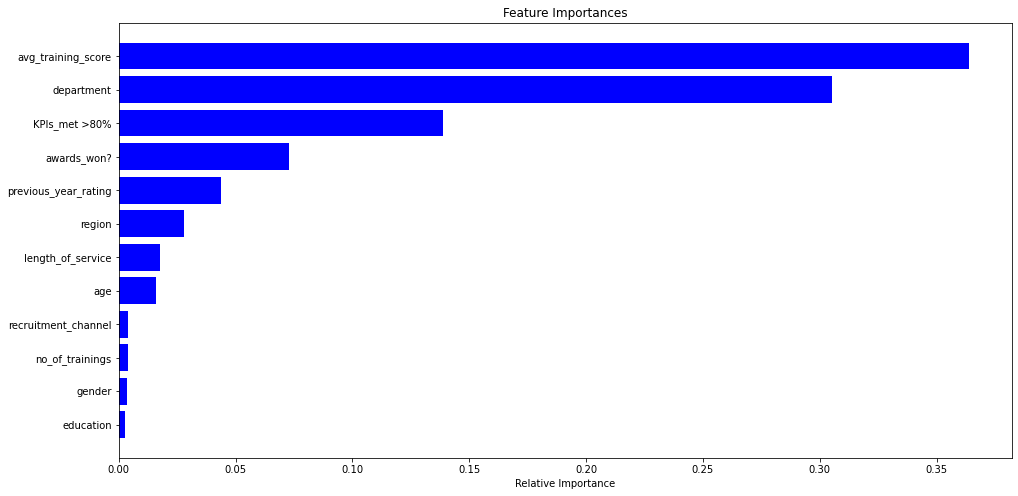

In [ ]:
# Feature Importances

features = X_train_processed.columns
importances = model_cv_gb.best_estimator_.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Test Set with Unknown outcomes (to be submitted to the competition)

In [ ]:
df_test = pd.read_csv("test_set.csv")
df_test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [ ]:
df_test = df_test.drop("employee_id",axis=1)

In [ ]:
External_X_test_processed = combined_pipe.transform(df_test)

In [ ]:
model_cv_gb.predict(External_X_test_processed)

array([0, 0, 0, ..., 0, 0, 1])

# Fin!